<a href="https://colab.research.google.com/github/nye0/SAM-Med2D/blob/main/predictor_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Set-up
edit from [sam colab](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb#scrollTo=MTeAdX_mHwAR)



If you're running this notebook locally using Jupyter, please clone `SAM-Med2D` into a directory named `SAM_Med2D`. Note that you do **not** need to install `segment_anything` in your local environment, as `SAM-Med2D` and `SAM` share function names that could lead to conflicts.

For Google Colab users: Set `using_colab=True` in the cell below before executing it. Although you can select 'GPU' under 'Edit' -> 'Notebook Settings' -> 'Hardware Accelerator', this notebook is designed to run efficiently in a CPU environment as well.



# SAM-Med2D generates predicted object masks based on prompts.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.array([0, 1, 0, 0.5])
    else:
        color = np.array([1, 0, 0, 0.5])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [3]:
import SimpleITK as sitk
from skimage.measure import label, regionprops

In [4]:
def visualize(slce, predict_mask, gt, points, labels, fn):
    plt.figure(figsize=(5,5))
    plt.imshow(slce, cmap='gray')
    show_mask(gt, plt.gca(), random_color=True)
    show_mask(predict_mask, plt.gca())
    show_points(points, labels, plt.gca())
    plt.axis('off')
    plt.show()
    # plt.savefig(f"output/{fn}")

In [5]:
def visualize(slce, predict_mask, gt, box, fn):
    plt.figure(figsize=(5,5))
    plt.imshow(slce, cmap='gray')
    show_mask(gt, plt.gca(), random_color=True)
    show_mask(predict_mask, plt.gca())
    show_box(box, plt.gca())
    plt.axis('off')
    plt.show()
    # plt.savefig(f"output/{fn}")

## Example image

## Load SAM-Med2D model

In [6]:
from segment_anything import sam_model_registry
from segment_anything.predictor_sammed import SammedPredictor
from argparse import Namespace
args = Namespace()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.image_size = 256
args.encoder_adapter = True
args.sam_checkpoint = "sam-med2d_b.pth"
model = sam_model_registry["vit_b"](args).to(device)
predictor = SammedPredictor(model)

True
*******load sam-med2d_b.pth


In [7]:
args = Namespace()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.image_size = 1024
args.encoder_adapter = False
args.sam_checkpoint = "/volume/willy-dev/sota/SAM-Med2D/sam_vit_b_01ec64.pth"
model2 = sam_model_registry["vit_b"](args).to(device)
predictor2 = SammedPredictor(model2)

*******load /volume/willy-dev/sota/SAM-Med2D/sam_vit_b_01ec64.pth


Process the image to produce an image embedding by calling `SammedPredictor.set_image`. `SammedPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [8]:
import glob
from tqdm import tqdm
import os
from collections import defaultdict

In [9]:
glob.glob('/volume/open-dataset-ssd/ai99/gen_data/*')

['/volume/open-dataset-ssd/ai99/gen_data/glioma',
 '/volume/open-dataset-ssd/ai99/gen_data/meningioma',
 '/volume/open-dataset-ssd/ai99/gen_data/neuroma',
 '/volume/open-dataset-ssd/ai99/gen_data/acoustic',
 '/volume/open-dataset-ssd/ai99/gen_data/meta',
 '/volume/open-dataset-ssd/ai99/gen_data/normal']

In [10]:
def norm_slce(slce):
    if torch.is_tensor(slce):
        slce = slce.cpu().numpy()
    slce -= slce.min()
    slce /= slce.max()
    slce *= 255
    slce = slce.astype(np.uint8)
    slce = np.stack([slce, slce, slce], axis=2)
    return slce

def get_side_pred(predictor, pred, img, gt, rot_point, centroid, offset):

    slce = norm_slce(rot_img[:, int(rot_point[1])])
    
    predictor.set_image(slce)
    input_point = [[int(rot_point[0]), centroid[0]]]
    input_label = [1]

    proj = torch.nonzero(gt[centroid[0], int(rot_point[1])])
    if proj.shape[0] > 0:

        proj_min, proj_max = proj.min().cpu().numpy(), proj.max().cpu().numpy()
        input_point += [[proj_min+5, centroid[0]], [proj_max-5, centroid[0]]]
        input_label += [1, 1]
        
    input_point = np.array(input_point)
    input_label = np.array(input_label)

    masks, scores, logits = predictor.predict(
                    point_coords=input_point,
                    point_labels=input_label,
                    multimask_output=True,
                )
    
    # visualize(slce, masks[0], gt[:, int(rot_point[1])].cpu().numpy(), input_point, input_label, f"{offset}.png")

    z = int(rot_point[1])

    pred[:, [z-1, z, z+1]] = torch.tensor(masks[0]).unsqueeze(1).repeat(1, 3, 1).cuda()

    return pred

import math
from torchvision.transforms.functional import rotate, InterpolationMode

def rotate_(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [12]:
dices = []
dicesb = []
dicesc = []
mms = []
mmms = []

for di in tqdm(glob.glob('/volume/open-dataset-ssd/ai99/gen_data/neuroma/*')):

    try:
        img = sitk.ReadImage(f'{di}/axc.nii.gz')
        img = sitk.GetArrayFromImage(img)

        mask = sitk.ReadImage(f'{di}/seg.nii.gz')
        mask = sitk.GetArrayFromImage(mask)
    except:
        continue

    # if img.shape[0] < 100:
        # continue

    mask = label(mask)

    for i, prop in enumerate(regionprops(mask)):
        
        if prop.area == 0:
            continue
            
        centroid = ((np.array(prop.bbox[:3]) + np.array(prop.bbox[3:]))/2).astype(int)
        
        degree = 15
        offset = 0
        
        rot_img = torch.tensor(img.astype(float)).cuda()
        rot_mask = torch.tensor(mask.astype(float)).cuda()
        rot_pred = torch.zeros_like(rot_img).float().cuda()
        rot_point = centroid[[2,1]].astype(float)
        
        slce = norm_slce(rot_img[:, int(rot_point[1])])
        rot_pred = get_side_pred(predictor, rot_pred, slce, rot_mask, rot_point, centroid, offset)
        
        while offset < 180:
            
            rot_img = rotate(rot_img, degree)
            rot_pred = rotate(rot_pred, degree)
            rot_mask = rotate(rot_mask, degree)
        
            rot_point = rotate_([rot_img.shape[1]//2, rot_img.shape[2]//2], rot_point, -degree * 0.0174533)
            
            rot_pred = get_side_pred(predictor, rot_pred, rot_img, rot_mask, rot_point, centroid, offset)
        
            offset += degree
            
        rot_pred = rotate(rot_pred, -offset)

        z_nonzero = torch.nonzero(rot_pred.sum((1,2))).flatten()
            
        dices_tp = 0
        dices_pred = 0

        del rot_img
        del rot_mask
            
        for z in z_nonzero:
            
            slce = img[z].astype(float)
            
            input_point = []
            input_label = []

            regionprop = regionprops(rot_pred[z].int().cpu().numpy())

            if len(regionprop) == 0:
                continue
            
            box, area = regionprop[0].bbox, regionprop[0].area

            gt = np.copy(mask[z])
            gt[gt!=(i+1)] = 0
            gt[gt==(i+1)] = 1
            
            if area > 100:
                pad = 1.
                h, w = box[3] - box[1], box[2] - box[0]
                y, x = (box[3] + box[1])/2, (box[2] + box[0])/2
                box = np.array([y-h/2*pad, x-w/2*pad, y+h/2*pad, x+w/2*pad])

                predictor2.set_image(norm_slce(slce))
                masks, scores, logits = predictor2.predict(
                    box = box,
                    multimask_output=False,
                )
            else:
                continue
            
            dices_tp += (gt*masks[0]).sum()
            dices_pred += masks[0].sum()

            # visualize(slce, masks[0], gt, input_point, input_label, f"{os.path.basename(di)}_{z}.jpg")
            
            dice = 2 * ((gt*masks[0]).sum() + 1e-5)/(gt.sum() + masks[0].sum() + 1e-5)
            dicesc.append(dice)
            mms.append(area)

        del rot_pred

        torch.cuda.empty_cache()
               
        dicesb_ = 2*dices_tp / (dices_pred + prop.area)
        dicesb.append(dicesb_)
        mmms.append(prop.area)

    # break


100%|█████████████████████████████████████████████████████████████████████████| 475/475 [20:18<00:00,  2.57s/it]


In [ ]:
import plotly.express as px

In [ ]:
np.save('tmp_dicesb.npy', dicesb)
np.save('tmp_dicesc.npy', dicesc)
np.save('tmp_mms.npy', mms)
np.save('tmp_mmms.npy', mmms)

In [24]:
dices = np.array(dices)
dicesb = np.array(dicesb)
dicesc = np.array(dicesc)
mms = np.array(mms)
mmms = np.array(mmms)

0.6467063832689529


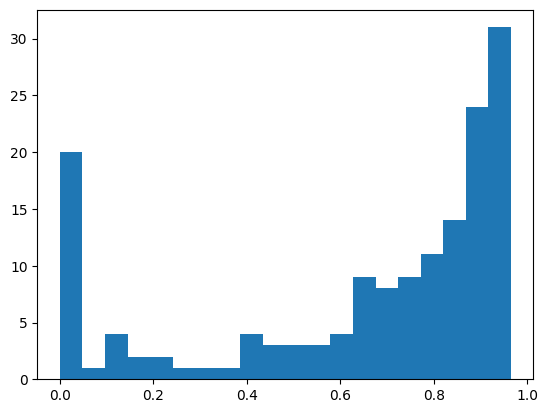

In [25]:
print(np.mean(dicesb[mmms > 0]))
plt.hist(dicesb[mmms > 0],bins=20)
plt.show()

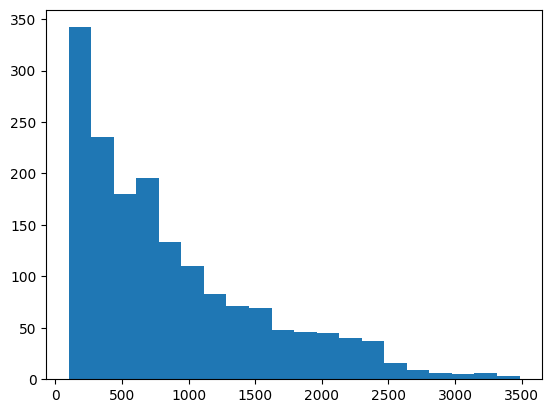

In [26]:
plt.hist(mms, bins=20)
plt.show()

0.6701930747536025


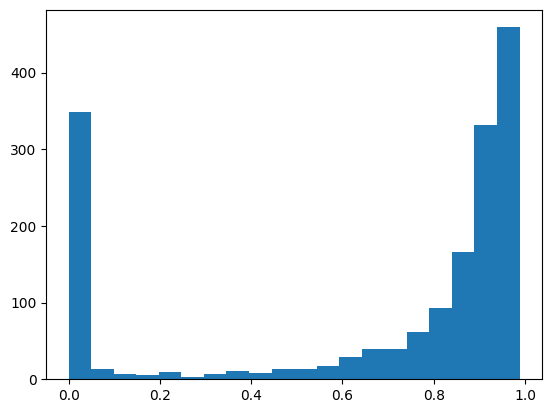

In [30]:
print(np.mean(dicesc[dicesc < 1]))
plt.hist(dicesc[dicesc < 1], bins=20)
plt.show()

In [ ]:
dicesc.shape

In [ ]:
np.array(dices)[np.array(mms) > 0].shape

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(slce)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(slce)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(slce)
show_mask(gt, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()


## Optimizing Segmentation Results by Point Interaction

In [ ]:
input_point1 = np.array([[169, 140]])
input_label1 = np.array([0])
input_points = np.concatenate((input_point, input_point1))
input_labels = np.concatenate((input_label, input_label1))
mask_inputs = torch.sigmoid(torch.as_tensor(logits, dtype=torch.float, device=device))

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    mask_input = mask_inputs,
    multimask_output=True,
)
masks.shape  # (number_of_masks) x H x W

In [ ]:

plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_points, input_labels, plt.gca())
plt.axis('off')
plt.show()

## Specifying a specific object with a bounding box

The model can also take a box as input, provided in xyxy format.

In [ ]:
image = cv2.imread('data_demo/images/s0114_111.png')
predictor.set_image(image)
input_box = np.array([89,43,113,64]) #

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box,
    multimask_output=True,
)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [ ]:
torch.cuda.empty_cache()

## Multiple bounding box prediction results

In [ ]:
input_boxes = torch.tensor([[72,110,136,143],[124,92,160,132]], device=predictor.device)

In [ ]:
transformed_boxes = predictor.apply_boxes_torch(input_boxes, image.shape[:2], (args.image_size, args.image_size))
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=True,
)
print(transformed_boxes.shape)
print(masks.shape)  # (batch_size) x (num_predicted_masks_per_input) x H x W

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

